# Import Dataset

In [1]:
import pandas as pd
import sqlite3 as sql
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
db_connection = sql.connect('data.sqlite3')

In [3]:
execute_sql = db_connection.cursor()

In [4]:
def read(sql_query):
    return pd.read_sql(sql_query, con = db_connection)

# Introduction

The dataset selected comes from Pitchfork's music reviews. The dataset consists of around 24 thousand reviews from January 5th, 1999 to December 12, 2021. These reviews come from the consensus of multiple music critics writing a review for an album and giving it a score from 0 to 10. The schema follows a main review dataset that contains a review for an album and a tombstones dataset that labels the score for a given album along with some relevant statistics. The rest of the tables are relational tables that give more information about the album and author. 

As a data analyst for Pitchfork I'd want to analyze some trends within the reviews. Some things I'd be able to analyze are score trends on different genres, reviews and scores throughout time, and patterns with the best new music feature.

# Average scores across all genres

What are the average scores across all genres?

In [7]:
que = """
SELECT genre, AVG(score) AS average_score
FROM genre_review_map AS a
INNER JOIN tombstones AS b
ON a.review_url = b.review_url
GROUP BY genre
ORDER BY AVG(score) DESC;
"""

genre_avg = read(que)
genre_avg

,genre,average_score
0,Global,7.561511
1,Jazz,7.464900
2,Experimental,7.401331
3,Folk/Country,7.261728
4,Metal,7.069934
5,Rock,7.041124
6,Electronic,7.027577
7,Pop/R&B,6.987107
8,Rap,6.958833


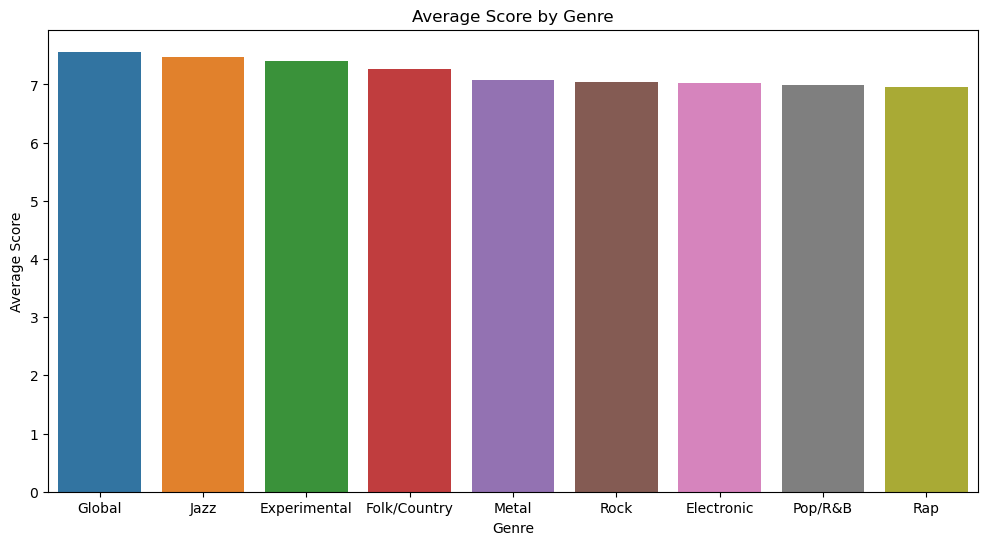

In [12]:
plt.figure(figsize=(12, 6))
sns.barplot(data=genre_avg, x='genre', y='average_score')
plt.title('Average Score by Genre')
plt.xlabel('Genre')
plt.ylabel('Average Score')
plt.show()

One of the compelling questions when dealing with ratings on music is what are the average scores per genre. This bar plot displays the average score across all genres ordered by their average score. Here, it seems like global appeals to the reviewers the highest at an average score of 7.56 while rap appeals the lowest at an average score of 6.95

# Top 5 most reviewed labels and their average scores

Which labels are reviewed the most and what are their average scores?

In [27]:
que = """
WITH label_count AS (
    SELECT label, score, COUNT(*) OVER (PARTITION BY label) AS num_reviews
    FROM tombstone_label_map AS a
    INNER JOIN tombstones AS b
    ON a.review_tombstone_id = b.review_tombstone_id
), label_rank AS (
    SELECT *, DENSE_RANK() OVER (ORDER BY num_reviews DESC) AS rank_num_reviews
    FROM label_count
)
SELECT label, AVG(score) AS average_score
FROM label_rank
WHERE rank_num_reviews <= 5
GROUP BY label
ORDER BY rank_num_reviews;

"""

label_avg_score = read(que)
label_avg_score

,label,average_score
0,self-released,7.032315
1,Interscope,6.723662
2,Sub Pop,7.185795
3,Columbia,7.045732
4,Drag City,7.247500


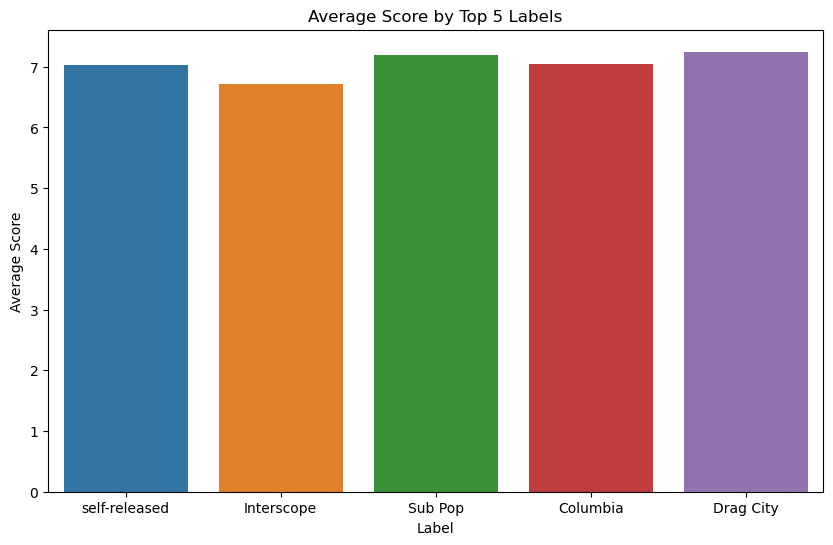

In [28]:
plt.figure(figsize=(10, 6))
sns.barplot(data=label_avg_score, x='label', y='average_score')
plt.title('Average Score by Top 5 Labels')
plt.xlabel('Label')
plt.ylabel('Average Score')
plt.show()

These are the top 5 most reviewed labels and their average scores. The bar plot is ordered from most popular label to least. Self released seems to be the most reviewed label as many albums released without a label are more likely to be categorized as self released. Drag City being the 5th most reviewed label seems to have the highest average score out of these 5s. 

# What are the top 10 artists per genre with the highest average score (with minimum 4 reviews). Order by average score per genre.

In [30]:
que = """
WITH count_artist AS (
    SELECT genre, name, score, 
        COUNT(*) OVER (
            PARTITION BY name
        ) AS num_reviews
    FROM artists AS a
    INNER JOIN artist_review_map AS b
    ON a.artist_id = b.artist_id
    INNER JOIN tombstones AS c
    ON b.review_url = c.review_url
    INNER JOIN genre_review_map AS d
    ON c.review_url = d.review_url
), avg_score AS (
    SELECT name, genre, AVG(score) AS average_score
    FROM count_artist
    WHERE num_reviews >= 4
    GROUP BY name
), ranked_artists AS (
    SELECT *, 
    RANK() OVER (
        PARTITION BY genre
        ORDER BY average_score DESC) AS genre_rank
    FROM avg_score
)
SELECT name, genre, average_score
FROM ranked_artists
WHERE genre_rank <= 10
ORDER BY genre, average_score DESC;
"""

read(que)
    
    

,name,genre,average_score
0,Liquid Liquid,Electronic,9.433333
1,Max Tundra,Electronic,9.000000
2,Television,Electronic,8.850000
3,13th Floor Elevators,Electronic,8.750000
4,FKA twigs,Electronic,8.700000
...,...,...,...
86,Roxy Music,Rock,8.730000
87,Tame Impala,Rock,8.700000
88,Fiona Apple,Rock,8.685714
89,Slowdive,Rock,8.620000


Here are the top 5 highest scoring artists. Interesting enough, the shoegaze band My Bloody Valentine is Pitchfork's favorite artist with an average score of 9.65. 

# One month rolling average score by genre

Answering this question can give a rough trend on scores by genre throughout the years. This could give insight on how genres were perceived throughout time.

In [32]:
que = """
WITH filt AS (
    SELECT strftime('%Y-%m', pub_date) AS date, genre, score
    FROM tombstones
    INNER JOIN reviews
    ON tombstones.review_url = reviews.review_url
    INNER JOIN genre_review_map
    ON reviews.review_url = genre_review_map.review_url
)
SELECT *, 
    AVG(score) OVER (
        PARTITION BY genre 
        ORDER BY date
        ROWS BETWEEN 12 PRECEDING AND CURRENT ROW) AS annual_rolling_avg
FROM filt
"""

rolling_avg = read(que)

In [33]:
rolling_avg.head()

,date,genre,score,annual_rolling_avg
0,1999-01,Electronic,8.9,8.900000
1,1999-01,Electronic,4.8,6.850000
2,1999-02,Electronic,8.0,7.233333
3,1999-02,Electronic,8.9,7.650000
4,1999-02,Electronic,7.4,7.600000


C:\Users\julia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\julia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


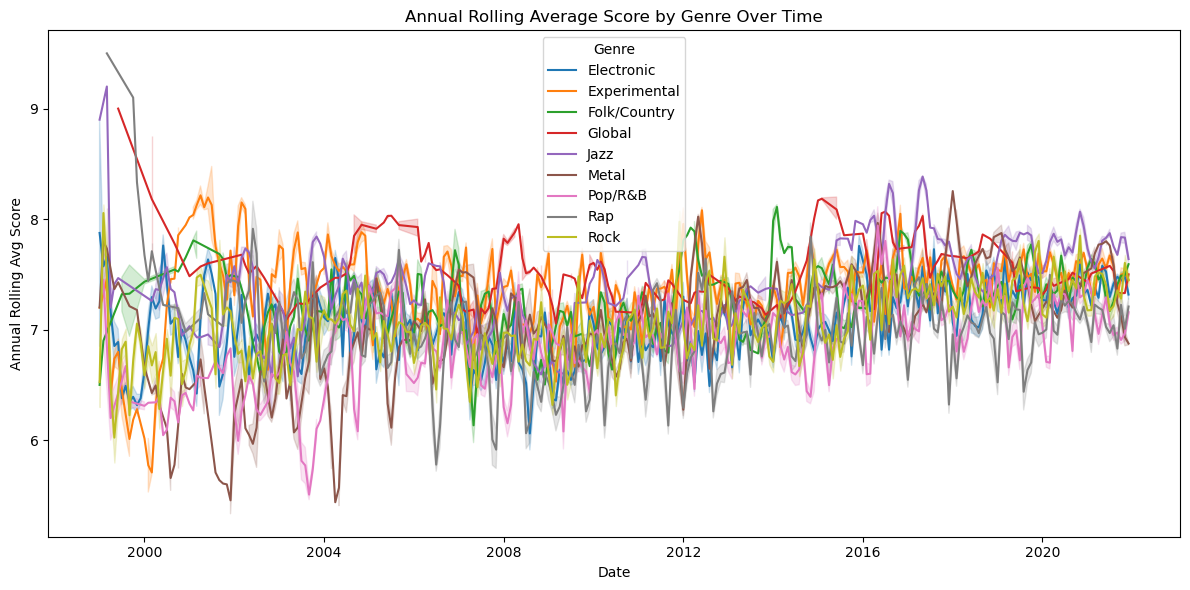

In [34]:


# Make sure your date column is in datetime format
rolling_avg['date'] = pd.to_datetime(rolling_avg['date'])

# Create the line plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=rolling_avg, x='date', y='annual_rolling_avg', hue='genre')

# Add titles and labels
plt.title('Annual Rolling Average Score by Genre Over Time')
plt.xlabel('Date')
plt.ylabel('Annual Rolling Avg Score')
plt.legend(title='Genre')
plt.tight_layout()
plt.show()


Scoring trends of genres throughout time. As seen from previous queries, global music seems to have a consistently high rolling average throughout time, landing the highest average score. Another interesting find is metal music, taking a toll in score after the 2000s and scoring low peaks of scores less than 6. The average score does seem to rise after 2004 and maintain consistent scoring throughout time. 

# Are there recency bias in reviews?

I first found the average years between the album's release year and the review publication date

In [39]:
que = """
WITH date_dif AS (
    SELECT CAST(strftime('%Y', pub_date) AS INTEGER) - release_year AS year_diff
    FROM reviews
    INNER JOIN tombstones
    ON reviews.review_url = tombstones.review_url
    INNER JOIN tombstone_release_year_map
    ON tombstones.review_tombstone_id = tombstone_release_year_map.review_tombstone_id 
)
SELECT AVG(year_diff) AS avg_review_diff
FROM date_dif;

"""

read(que)

,avg_review_diff
0,1.811944


There seems to be at least a year difference between album release and its review. This makes sense since many albums were released before Pitchfork existed, but this poses the question on whether recency bias exists. For simplicity, a review is considered recent if the review was posted within the same year as the album. 

In [58]:


que = """
SELECT score,
    CASE WHEN CAST(strftime('%Y', pub_date) AS INTEGER) = CAST(release_year AS INTEGER) THEN 'Recent'
        ELSE 'Non-Recent' END AS review_distance
FROM reviews AS a
INNER JOIN tombstones AS b
ON a.review_url = b.review_url
INNER JOIN tombstone_release_year_map AS c
ON b.review_tombstone_id = c.review_tombstone_id;
"""

recency = read(que)

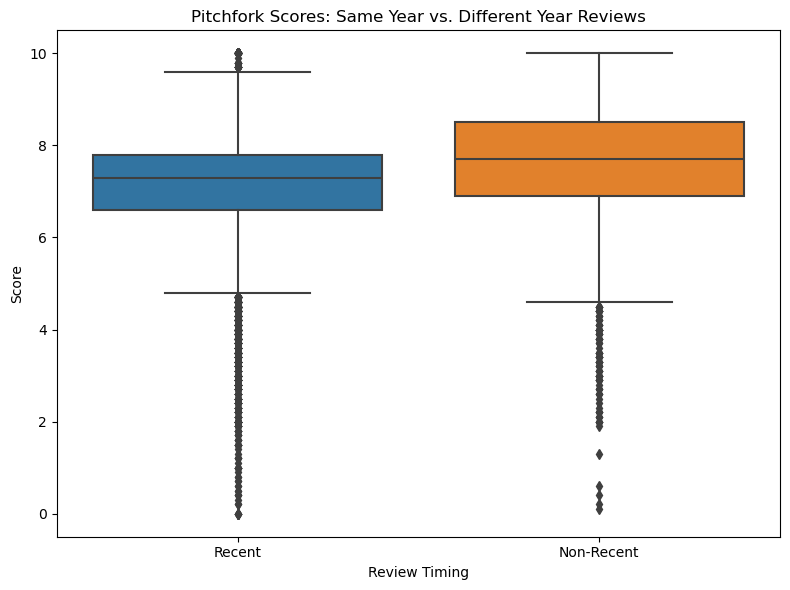

In [60]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=recency, x='review_distance', y='score')
plt.title('Pitchfork Scores: Same Year vs. Different Year Reviews')
plt.xlabel('Review Timing')
plt.ylabel('Score')
plt.tight_layout()
plt.show()

It seems like there is a difference in scores. A two-sample T-Test is conducted to confirm our reasonings

In [61]:
from scipy.stats import ttest_ind

recent_scores = recency[recency['review_distance'] == 'Recent']['score']
nonrecent_scores = recency[recency['review_distance'] == 'Non-Recent']['score']
t_stat, p_value = ttest_ind(recent_scores, nonrecent_scores, equal_var=False) 

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")


T-statistic: -20.3354
P-value: 0.0000


With a p-value of 0, this confirms that there are differences in review scores. It actually seems like there's recency bias against albums as the box plot shows lower scores for recent reviews. This could be explained as many albums released before Pitchfork are considered among the greatest with its reputation only increasing throughout time. 

# Find the top reviewer for each Label

To commemorate their reviewers, each label wants to commemorate the reviewer that has reviewed the most albums from their label. Find the author who has reviewed the most albums from each label. Labels will only commemorate the reviewer if they have have written 5 or more reviews from such label.

In [74]:
que = """
WITH count_rev AS (
    SELECT label, author, 
        COUNT(*) AS author_count
    FROM tombstone_label_map AS a
    INNER JOIN tombstones AS b
    ON a.review_tombstone_id = b.review_tombstone_id
    INNER JOIN author_review_map AS c
    ON b.review_url = c.review_url
    GROUP BY label, author
), rank_count AS (
    SELECT *, 
        RANK() OVER (
            PARTITION BY label ORDER BY author_count DESC) AS author_rank
    FROM count_rev
)
SELECT label, author, author_count AS num_of_reviews
FROM rank_count
WHERE author_rank = 1 AND num_of_reviews >= 5
ORDER BY author_count DESC
LIMIT 10;
"""

read(que)

,label,author,num_of_reviews
0,Legacy,Stephen Thomas Erlewine,44
1,self-released,Ian Cohen,36
2,Thrill Jockey,Mark Richardson,35
3,Anti-,Stephen M. Deusner,31
4,Warp,Mark Richardson,28
5,Columbia,Stephen M. Deusner,27
6,Numero Group,Joe Tangari,26
7,Polyvinyl,Ian Cohen,26
8,Rhino,Stephen M. Deusner,26
9,Sub Pop,Ian Cohen,25


The table shows how many reviews the top author has written for a label. For example, here we see that the Legacy label will commemorate Stephen Thomas Erlewine as they wrote the most amount of reviews for them at 44 reviews. 

# How do debut albums do compared to its other albums

Only artists with at least 3 albums reviewed will be considered. Some albums may be released in the same year as their debut album so an average will just be considered in this case as realistically, both those albums are still in an artist's early stages.

In [41]:
que = """
WITH count_artist AS (
    SELECT name, release_year, title, score,
        COUNT(*) OVER (
            PARTITION BY name
        ) AS num_reviews
    FROM artists AS a
    INNER JOIN artist_review_map AS b
    ON a.artist_id = b.artist_id
    INNER JOIN tombstones AS c
    ON b.review_url = c.review_url
    INNER JOIN tombstone_release_year_map AS d
    ON c.review_tombstone_id = d.review_tombstone_id
), filt AS (
    SELECT *, 
        RANK() OVER (
            PARTITION BY name
            ORDER BY release_year
        ) AS release_order
    FROM count_artist
    WHERE num_reviews >= 3
), debut AS (
    SELECT name, release_year AS debut_year, AVG(score) AS debut_score
    FROM filt
    WHERE release_order = 1
    GROUP BY name
), average_score AS (
    SELECT name, AVG(score) AS avg_album_score
    FROM filt
    WHERE release_order > 1
    GROUP BY name
)
SELECT debut.name, debut_year, debut_score, avg_album_score
FROM debut
INNER JOIN average_score
ON debut.name = average_score.name
ORDER BY debut_score DESC;
    
"""



debut = read(que)

In [42]:
debut.head()

,name,debut_year,debut_score,avg_album_score
0,A Tribe Called Quest,1990,10.0,9.500000
1,Alice Coltrane,1971,10.0,8.540000
2,Björk,1995,10.0,7.177778
3,Bonnie “Prince” Billy,1999,10.0,7.189286
4,Can,1971,10.0,8.050000


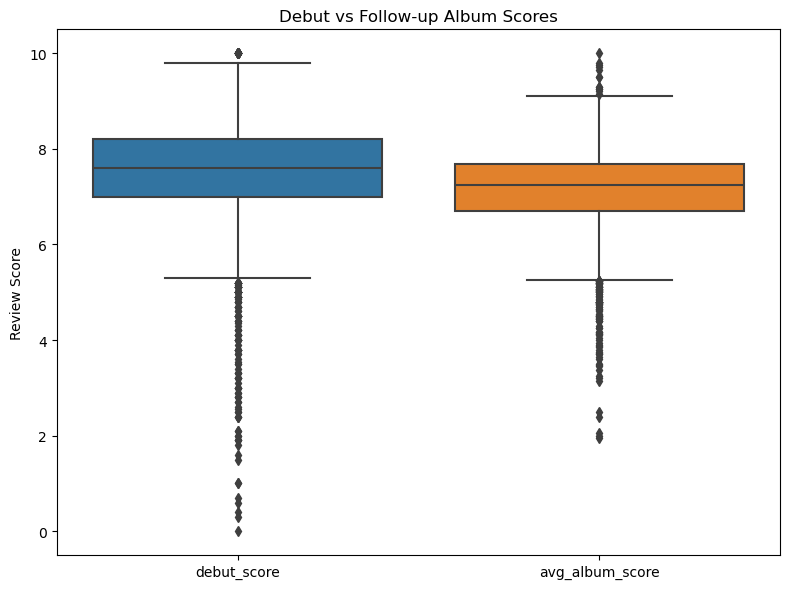

In [46]:

debut_adj = debut.melt(id_vars='name', 
                    value_vars=['debut_score', 'avg_album_score'],
                    var_name='album_type',
                    value_name='score')

plt.figure(figsize=(8, 6))
sns.boxplot(data=debut_adj, x='album_type', y='score')
plt.title('Debut vs Follow-up Album Scores')
plt.ylabel('Review Score')
plt.xlabel('')
plt.tight_layout()
plt.show()

# Percentage of best new music albums that are not in the top 15% highly rated scores

First I analyzed which best new music albums aren't in the top 15% rated scores

In [99]:
que = """
WITH ranked_scores AS (
    SELECT title, score, best_new_music,
           PERCENT_RANK() OVER (ORDER BY score) AS percent_rank
    FROM tombstones
)
SELECT title, score
FROM ranked_scores
WHERE percent_rank < 0.85 AND best_new_music = 1;

"""

read(que)

,title,score
0,Let's Get Serious EP,7.9
1,The Black Album,8.0
2,The Ecstatic,8.0
3,Culture,8.1
4,Fever Ray,8.1
5,Sisterworld,8.1
6,Sometimes I Wish We Were an Eagle,8.1
7,Sumday,8.1
8,Seven Swans,8.1
9,Castaways and Cutouts,8.1


These albums were given best new music but aren't in the top 15% rated. The percentage of these albums compared to others in best new music is calculated below:

In [98]:
que = """
WITH ranked_scores AS (
    SELECT title, score, best_new_music,
           PERCENT_RANK() OVER (ORDER BY score) AS percent_rank
    FROM tombstones
), counts AS (
    SELECT COUNT(*) AS bnm_count, 
        SUM( CASE WHEN percent_rank < 0.85 THEN 1 ELSE 0 END) AS top_15
    FROM ranked_scores
    WHERE best_new_music = 1
)
SELECT 1.0 * top_15 / bnm_count AS non_highly_rated_percentage
FROM counts

"""

read(que)

,non_highly_rated_percentage
0,0.014303


Approximately 1.4% of albums that were given best new music weren't in the top 15% of scores. This implies that a majority of best new music albums are highly rated.